<a href="https://colab.research.google.com/github/infected4098/22f-voice-conversion-project-reposit/blob/main/MultibandMelGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0: Intro 

본 코드는 MelGAN 및 Multiband melgan을 소개하고 코드를 리뷰하는 차원의 overview이다. 설명의 편의성을 위해 생략한 부분이 있어 이 코드를 그대로 실행할 수는 없다. 모델의 실제 학습 및 기용은 여타 코드를 참조하자.

본 프로젝트에 활용한 Multiband-MelGAN은 MelGAN을 상속한다. Chapter 0에서는 먼저 MelGAN 모델 관련 코드를 소개한다. 이후 Chapter 1에서 Multiband-MelGAN을 정의한 뒤 Chapter 3에서는 실제 모델 기용 및 학습을 위한 phase에 대한 코드를 소개한다.

코드의 실질적인 적용을 위해서는 Chapter 3를 우선적으로 보는 것을 추천한다.

# 0.1: Setting directory & Git clone 

In [ ]:
#드라이브 세팅.
from google.colab import drive
drive.mount("your google drive")
import os
os.chdir('your directory')
print(os.getcwd())

#라이브러리 임포트를 위한 git clone 디렉토리 추가.
import sys
sys.path.append("your directory")


#원본 git clone.
! pip install TensorFlowTTS 



# 1.0: MelGAN Config

In [ ]:
#yaml 파일 세팅이므로 config를 파일로 직접 불러오는 것이 좋음.

"""
###########################################################
#                FEATURE EXTRACTION SETTING               #
###########################################################
sampling_rate: 22050     # 데이터셋의 Sampling rate. 활용 데이터 전처리 시의 Sampling rate 과 일치해야 한다. KSS dataset의 경우는 22050.
hop_size: 256            # Hop size.
format: "npy"            # numpy파일로 저장.


###########################################################
#         GENERATOR NETWORK ARCHITECTURE SETTING          #
###########################################################
model_type: "melgan_generator"

melgan_generator_params:
    out_channels: 1               # Output channel의 수.
    kernel_size: 7                # 초기, 말기 convolution filter의 kernel_size.
    filters: 512                  # Initial number of channels for conv layers.
    upsample_scales: [8, 8, 2, 2] # Transposed convolution을 위한 Upsampling 스케일.
    stack_kernel_size: 3          # Residual stack에 사용되는 Dilated convolution kernel size 설정.
    stacks: 3                     # 각 Residual stack에 포함되는 Dilated convolution의 stack 개수. 디폴트는 3.
    is_weight_norm: false         # 정규화 방법 설정.

###########################################################
#       DISCRIMINATOR NETWORK ARCHITECTURE SETTING        #
###########################################################
melgan_discriminator_params:
    out_channels: 1                   # Output channel의 개수.
    scales: 3                         # Discriminator 연산의 scale 개수. 디폴트는 3.
    downsample_pooling: "AveragePooling1D"   # 매 Scale 전환 시 Pooling 방식.
    downsample_pooling_params:        # downsampling 하이퍼파라미터.
        pool_size: 4
        strides: 2
    kernel_sizes: [5, 3]              # 커널 사이즈.
    filters: 16                       # Feature map 생성을 위한 초기 convolution filter 개수 설정.
    max_downsample_filters: 1024      
    downsample_scales: [4, 4, 4, 4]   # Downsampling scale. 매 downsampling마다 4번씩.
    nonlinear_activation: "LeakyReLU" # 활성화 함수 종류.
    nonlinear_activation_params:      # 활성화 함수에 사용되는 alpha.
        alpha: 0.2
    is_weight_norm: false             # 정규화 방법 설정.

###########################################################
#               ADVERSARIAL LOSS SETTING                  #
###########################################################
lambda_feat_match: 10.0 #Discriminator loss와 Feature matching loss의 가중합으로 이루어진 MelGAN LOSS에서 lambda 값 설정. 디폴트는 10.

###########################################################
#                  DATA LOADER SETTING                    #
###########################################################
batch_size: 16                 # 배치 사이즈.
batch_max_steps: 8192          
batch_max_steps_valid: 81920   
remove_short_samples: true    
allow_cache: true              
is_shuffle: true               

###########################################################
#             OPTIMIZER & SCHEDULER SETTING               #
###########################################################
generator_optimizer_params:
    lr: 0.0001             # Generator 모델 학습률.
    beta_1: 0.5
    beta_2: 0.9
    
discriminator_optimizer_params:
    lr: 0.0001            # Discriminator 모델 학습률.
    beta_1: 0.5
    beta_2: 0.9           

gradient_accumulation_steps: 1
###########################################################
#                    INTERVAL SETTING                     #
###########################################################
train_max_steps: 4000000                # 초기 Training step 설정.
save_interval_steps: 3               
eval_interval_steps: 2              
log_interval_steps: 1                # 학습 기록 남기기 위한 interval steps.
discriminator_train_start_steps: 0     # Discriminator 모델 학습 시작 step. 

###########################################################
#                     OTHER SETTING                       #
###########################################################
num_save_intermediate_results: 1  # Number of batch to be saved as intermediate results.
"""

In [ ]:
#from tensorflow_tts.configs import BaseConfig


class MelGANGeneratorConfig(BaseConfig):
    """MelGAN Generator Config 구성하는 객체를 정의."""

    def __init__(
        self,
        out_channels=1,
        kernel_size=7,
        filters=512,
        use_bias=True,
        upsample_scales=[8, 8, 2, 2],
        stack_kernel_size=3,
        stacks=3,
        nonlinear_activation="LeakyReLU",
        nonlinear_activation_params={"alpha": 0.2},
        padding_type="REFLECT",
        use_final_nolinear_activation=True,
        is_weight_norm=True,
        initializer_seed=42,
        **kwargs
    ):
       
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.filters = filters
        self.use_bias = use_bias
        self.upsample_scales = upsample_scales
        self.stack_kernel_size = stack_kernel_size
        self.stacks = stacks
        self.nonlinear_activation = nonlinear_activation
        self.nonlinear_activation_params = nonlinear_activation_params
        self.padding_type = padding_type
        self.use_final_nolinear_activation = use_final_nolinear_activation
        self.is_weight_norm = is_weight_norm
        self.initializer_seed = initializer_seed


class MelGANDiscriminatorConfig(object):
    """MelGAN Discriminator Config 구성하는 객체를 정의."""

    def __init__(
        self,
        out_channels=1,
        scales=3,
        downsample_pooling="AveragePooling1D",
        downsample_pooling_params={"pool_size": 4, "strides": 2,},
        kernel_sizes=[5, 3],
        filters=16,
        max_downsample_filters=1024,
        use_bias=True,
        downsample_scales=[4, 4, 4, 4],
        nonlinear_activation="LeakyReLU",
        nonlinear_activation_params={"alpha": 0.2},
        padding_type="REFLECT",
        is_weight_norm=True,
        initializer_seed=42,
        **kwargs
    ):
       
        self.out_channels = out_channels
        self.scales = scales
        self.downsample_pooling = downsample_pooling
        self.downsample_pooling_params = downsample_pooling_params
        self.kernel_sizes = kernel_sizes
        self.filters = filters
        self.max_downsample_filters = max_downsample_filters
        self.use_bias = use_bias
        self.downsample_scales = downsample_scales
        self.nonlinear_activation = nonlinear_activation
        self.nonlinear_activation_params = nonlinear_activation_params
        self.padding_type = padding_type
        self.is_weight_norm = is_weight_norm
        self.initializer_seed = initializer_seed

# 1.1: MelGAN Dataset

In [ ]:
"""데이터셋 모듈."""
"""Vocoder 모델 특성상 Mel Spectrogram, Waveform 이 쌍으로 있어야 학습할 수 있음."""

import logging
import os

import numpy as np
import tensorflow as tf
from tensorflow_tts.datasets.abstract_dataset import AbstractDataset
from tensorflow_tts.utils import find_files


class AudioMelDataset(AbstractDataset):
    """Target Data인 Waveform, Train Data인 Mel Spectrogram을 저장하는 객체 생성."""

    def __init__(
        self,
        root_dir,
        audio_query="*-wave.npy",
        mel_query="*-raw-feats.npy",
        audio_load_fn=np.load,
        mel_load_fn=np.load,
        audio_length_threshold=0,
        mel_length_threshold=0,
    ):
        
        # 디렉토리 내 wav 음성과 Mel Spectrogram 불러오기.
        audio_files = sorted(find_files(root_dir, audio_query))
        mel_files = sorted(find_files(root_dir, mel_query))

        # mel-wav 가 짝이 맞는지 개수 확인.
        assert len(audio_files) != 0, f"Not found any audio files in ${root_dir}."
        assert len(audio_files) == len(
            mel_files
        ), f"Number of audio and mel files are different ({len(audio_files)} vs {len(mel_files)})."

        if ".npy" in audio_query:
            suffix = audio_query[1:]
            utt_ids = [os.path.basename(f).replace(suffix, "") for f in audio_files]

        # utt_ids 는 여러 명의 화자 목소리로 학습된 multi-speaker vocoder를 위한 parameters. 단일 화자일 때에는 NULL.
        self.utt_ids = utt_ids
        self.audio_files = audio_files
        self.mel_files = mel_files
        self.audio_load_fn = audio_load_fn
        self.mel_load_fn = mel_load_fn
        self.audio_length_threshold = audio_length_threshold
        self.mel_length_threshold = mel_length_threshold

    def get_args(self):
        return [self.utt_ids]

    def generator(self, utt_ids):
        for i, utt_id in enumerate(utt_ids):
            audio_file = self.audio_files[i]
            mel_file = self.mel_files[i]

            items = {
                "utt_ids": utt_id,
                "audio_files": audio_file,
                "mel_files": mel_file,
            }

            yield items

    @tf.function
    def _load_data(self, items):
        audio = tf.numpy_function(np.load, [items["audio_files"]], tf.float32)
        mel = tf.numpy_function(np.load, [items["mel_files"]], tf.float32)

        items = {
            "utt_ids": items["utt_ids"],
            "audios": audio,
            "mels": mel,
            "mel_lengths": len(mel),
            "audio_lengths": len(audio),
        }

        return items

    def create(
        self,
        allow_cache=False,
        batch_size=1,
        is_shuffle=False,
        map_fn=None,
        reshuffle_each_iteration=True,
    ):
        """Create tf.dataset function."""
        output_types = self.get_output_dtypes()
        datasets = tf.data.Dataset.from_generator(
            self.generator, output_types=output_types, args=(self.get_args())
        )
        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
        datasets = datasets.with_options(options)
        datasets = datasets.map(
            lambda items: self._load_data(items), tf.data.experimental.AUTOTUNE
        )
        #mel과 wav의 길이가 너무 긴 것을 방지하고자 함. 최대한 1~5초 내로 mel, wav를 만드는 것이 좋은 보코딩 품질을 만들 수 있음.
        datasets = datasets.filter(
            lambda x: x["mel_lengths"] > self.mel_length_threshold
        )
        datasets = datasets.filter(
            lambda x: x["audio_lengths"] > self.audio_length_threshold
        )

        if allow_cache:
            datasets = datasets.cache()

        if is_shuffle:
            datasets = datasets.shuffle(
                self.get_len_dataset(),
                reshuffle_each_iteration=reshuffle_each_iteration,
            )

        if batch_size > 1 and map_fn is None:
            raise ValueError("map function must define when batch_size > 1.")

        if map_fn is not None:
            datasets = datasets.map(map_fn, tf.data.experimental.AUTOTUNE)

      
        padded_shapes = {
            "utt_ids": [],
            "audios": [None],
            "mels": [None, 80],
            "mel_lengths": [],
            "audio_lengths": [],
        }

        padding_values = {
            "utt_ids": "",
            "audios": 0.0,
            "mels": 0.0,
            "mel_lengths": 0,
            "audio_lengths": 0,
        }

        datasets = datasets.padded_batch(
            batch_size,
            padded_shapes=padded_shapes,
            padding_values=padding_values,
            drop_remainder=True,
        )
        datasets = datasets.prefetch(tf.data.experimental.AUTOTUNE)
        return datasets

    def get_output_dtypes(self):
        output_types = {
            "utt_ids": tf.string,
            "audio_files": tf.string,
            "mel_files": tf.string,
        }
        return output_types

    def get_len_dataset(self):
        return len(self.utt_ids)

    def __name__(self):
        return "AudioMelDataset"

In [ ]:
# Train, Valid dataset을 따로 만드는 부분.
 """Train 데이터셋 정의"""
  train_dataset = AudioMelDataset(
      root_dir=args.train_dir,
      audio_query=audio_query,
      mel_query=mel_query,
      audio_load_fn=audio_load_fn,
      mel_load_fn=mel_load_fn,
      mel_length_threshold=mel_length_threshold,
  ).create(
      is_shuffle=config["is_shuffle"],
      map_fn=lambda items: collater(
          items,
          batch_max_steps=tf.constant(config["batch_max_steps"], dtype=tf.int32),
          hop_size=tf.constant(config["hop_size"], dtype=tf.int32),
      ),
      allow_cache=config["allow_cache"],
      batch_size=config["batch_size"]
      * STRATEGY.num_replicas_in_sync
      * config["gradient_accumulation_steps"],
  )


 """valid 데이터셋 정의."""

  valid_dataset = AudioMelDataset(
      root_dir=args.dev_dir,
      audio_query=audio_query,
      mel_query=mel_query,
      audio_load_fn=audio_load_fn,
      mel_load_fn=mel_load_fn,
      mel_length_threshold=mel_length_threshold,
  ).create(
      is_shuffle=config["is_shuffle"],
      map_fn=lambda items: collater(
          items,
          batch_max_steps=tf.constant(
              config["batch_max_steps_valid"], dtype=tf.int32
          ),
          hop_size=tf.constant(config["hop_size"], dtype=tf.int32),
      ),
      allow_cache=config["allow_cache"],
      batch_size=config["batch_size"] * STRATEGY.num_replicas_in_sync,
  )

# 1.2: MelGAN model

In [ ]:
"""기초 모델 작성."""

from tensorflow_tts.utils.utils import MODEL_FILE_NAME, CONFIG_FILE_NAME


class BaseModel(tf.keras.Model):
    def set_config(self, config):
        self.config = config

    def save_pretrained(self, saved_path):
        """Save config and weights to file."""
        os.makedirs(saved_path, exist_ok=True)
        self.config.save_pretrained(saved_path)
        self.save_weights(os.path.join(saved_path, MODEL_FILE_NAME))

In [ ]:
from tensorflow_tts.models import BaseModel
from tensorflow_tts.utils import GroupConv1D, WeightNormalization


def get_initializer(initializer_seed=42):
    
    return tf.keras.initializers.GlorotNormal(seed=initializer_seed)


class TFReflectionPad1d(tf.keras.layers.Layer):
    """Tensorflow ReflectionPad1d module."""

    def __init__(self, padding_size, padding_type="REFLECT", **kwargs):
        """Initialize TFReflectionPad1d module.
        Args:
            padding_size (int)
            padding_type (str): Padding 방식으로 constant, reflect 등 다양한 type 중 선택 가능한데 MB-MelGAN에서는 Reflect를 디폴트로 사용함.
        """
        super().__init__(**kwargs)
        self.padding_size = padding_size
        self.padding_type = padding_type

    def call(self, x):
        """Calculate forward propagation.
        Args:
            x (Tensor): Input tensor (B, T, C).
        Returns:
            Tensor: Padded tensor (B, T + 2 * padding_size, C).
        """
        return tf.pad(
            x,
            [[0, 0], [self.padding_size, self.padding_size], [0, 0]],
            self.padding_type,
        )


class TFConvTranspose1d(tf.keras.layers.Layer):
    """Tensorflow ConvTranspose1d module."""
    """Audio dataset 특성상 frame 수가 굉장히 많아서 transposed convolution 을 활용하여 Upsampling 을 진행함."""

    def __init__(
        self,
        filters,
        kernel_size,
        strides,
        padding,
        is_weight_norm,
        initializer_seed,
        **kwargs
    ):
        """Initialize TFConvTranspose1d( module.
        Args:
            filters (int): Number of filters.
            kernel_size (int): kernel size.
            strides (int): Stride width.
            padding (str): Padding type ("same" or "valid").
        """
        super().__init__(**kwargs)
        self.conv1d_transpose = tf.keras.layers.Conv2DTranspose(
            filters=filters,
            kernel_size=(kernel_size, 1),
            strides=(strides, 1),
            padding="same",
            kernel_initializer=get_initializer(initializer_seed),
        )
        if is_weight_norm:
            self.conv1d_transpose = WeightNormalization(self.conv1d_transpose)

    def call(self, x):
        """Calculate forward propagation.
        Args:
            x (Tensor): Input tensor (B, T, C).
        Returns:
            Tensor: Output tensor (B, T', C').
        """
        x = tf.expand_dims(x, 2)
        x = self.conv1d_transpose(x)
        x = tf.squeeze(x, 2)
        return x


class TFResidualStack(tf.keras.layers.Layer):
    """Upsampling 된 Input data가 Residual stack에 들어가게 됨."""
    """Residual stack은 residual, Dilated convolution 연산이 3번 나란히 이루어짐."""

    def __init__(
        self,
        kernel_size,
        filters,
        dilation_rate,
        use_bias,
        nonlinear_activation,
        nonlinear_activation_params,
        is_weight_norm,
        initializer_seed,
        **kwargs
    ):
        """Initialize TFResidualStack module.
        Args:
            kernel_size (int): Kernel size.
            filters (int): Number of filters.
            dilation_rate (int): Dilation rate.
            use_bias (bool): Whether to add bias parameter in convolution layers.
            nonlinear_activation (str): Activation function module name.
            nonlinear_activation_params (dict): Hyperparameters for activation function.
        """
        super().__init__(**kwargs)
        self.blocks = [
            getattr(tf.keras.layers, nonlinear_activation)(
                **nonlinear_activation_params
            ),
            TFReflectionPad1d((kernel_size - 1) // 2 * dilation_rate),
            tf.keras.layers.Conv1D(
                filters=filters,
                kernel_size=kernel_size,
                dilation_rate=dilation_rate, #dilation_rate를 설정해 줌으로서 MelGAN에서 활용하는 dilated convolution 연산을 수행할 수 있게 함.
                use_bias=use_bias,
                kernel_initializer=get_initializer(initializer_seed),
            ),
            getattr(tf.keras.layers, nonlinear_activation)(
                **nonlinear_activation_params
            ),
            tf.keras.layers.Conv1D(
                filters=filters,
                kernel_size=1,
                use_bias=use_bias,
                kernel_initializer=get_initializer(initializer_seed),
            ),
        ]
        self.shortcut = tf.keras.layers.Conv1D(
            filters=filters,
            kernel_size=1,
            use_bias=use_bias,
            kernel_initializer=get_initializer(initializer_seed),
            name="shortcut",
        )

        # apply weightnorm.
        if is_weight_norm:
            self._apply_weightnorm(self.blocks)
            self.shortcut = WeightNormalization(self.shortcut)

    def call(self, x):
        """Calculate forward propagation.
        Args:
            x (Tensor): Input tensor (B, T, C).
        Returns:
            Tensor: Output tensor (B, T, C).
        """
        _x = tf.identity(x)
        for layer in self.blocks:
            _x = layer(_x)
        shortcut = self.shortcut(x)
        return shortcut + _x

    def _apply_weightnorm(self, list_layers):
        """Try apply weightnorm for all layer in list_layers."""
        for i in range(len(list_layers)):
            try:
                layer_name = list_layers[i].name.lower()
                if "conv1d" in layer_name or "dense" in layer_name:
                    list_layers[i] = WeightNormalization(list_layers[i])
            except Exception:
                pass


class TFMelGANGenerator(BaseModel):
    """Tensorflow MelGAN generator module."""

    def __init__(self, config, **kwargs):
        """Initialize TFMelGANGenerator module.
        Args:
            config: config object of Melgan generator.
        """
        super().__init__(**kwargs)

      
        assert config.filters >= np.prod(config.upsample_scales)
        assert config.filters % (2 ** len(config.upsample_scales)) == 0

        # Generator 모델의 layers list 생성.
        layers = []
        layers += [
            TFReflectionPad1d(
                (config.kernel_size - 1) // 2,
                padding_type=config.padding_type,
                name="first_reflect_padding",
            ),
            tf.keras.layers.Conv1D(
                filters=config.filters,
                kernel_size=config.kernel_size,
                use_bias=config.use_bias,
                kernel_initializer=get_initializer(config.initializer_seed),
            ),
        ]

        for i, upsample_scale in enumerate(config.upsample_scales):
            # Transposed convolution으로 수행되는 upsampling은 총 4번. [8, 8, 2, 2]인 upsample_scales에 맞추어 연산됨.
            layers += [
                getattr(tf.keras.layers, config.nonlinear_activation)(
                    **config.nonlinear_activation_params
                ),
                TFConvTranspose1d(
                    filters=config.filters // (2 ** (i + 1)),
                    kernel_size=upsample_scale * 2,
                    strides=upsample_scale,
                    padding="same",
                    is_weight_norm=config.is_weight_norm,
                    initializer_seed=config.initializer_seed,
                    name="conv_transpose_._{}".format(i),
                ),
            ]

            # 매 upsampling 이후에 residual stack을 세 개 생성. 위 MelGAN config에서 stack=3으로 설정한 바 있음.

            for j in range(config.stacks):
                layers += [
                    TFResidualStack(
                        kernel_size=config.stack_kernel_size,
                        filters=config.filters // (2 ** (i + 1)),
                        dilation_rate=config.stack_kernel_size ** j,
                        use_bias=config.use_bias,
                        nonlinear_activation=config.nonlinear_activation,
                        nonlinear_activation_params=config.nonlinear_activation_params,
                        is_weight_norm=config.is_weight_norm,
                        initializer_seed=config.initializer_seed,
                        name="residual_stack_._{}._._{}".format(i, j),
                    )
                ]
        #이렇게 되면 총 16개로 된 layers 들이 생성됨. 이제 padding과 convolution 을 하는 final layer를 생성할 차례.
        # add final layer.
        layers += [
            getattr(tf.keras.layers, config.nonlinear_activation)(
                **config.nonlinear_activation_params
            ),
            TFReflectionPad1d(
                (config.kernel_size - 1) // 2,
                padding_type=config.padding_type,
                name="last_reflect_padding",
            ),
            tf.keras.layers.Conv1D(
                filters=config.out_channels,
                kernel_size=config.kernel_size,
                use_bias=config.use_bias,
                kernel_initializer=get_initializer(config.initializer_seed),
                dtype=tf.float32,
            ),
        ]
        if config.use_final_nolinear_activation:
            layers += [tf.keras.layers.Activation("tanh", dtype=tf.float32)]

        if config.is_weight_norm is True:
            self._apply_weightnorm(layers)

        self.melgan = tf.keras.models.Sequential(layers)

    def call(self, mels, **kwargs):
        """Calculate forward propagation.
        Args:
            c (Tensor): Input tensor (B, T, channels)
        Returns:
            Tensor: Output tensor (B, T ** prod(upsample_scales), out_channels)
        """
        return self.inference(mels)

    @tf.function(
        input_signature=[
            tf.TensorSpec(shape=[None, None, 80], dtype=tf.float32, name="mels")
        ]
    )
    #Mel spectrogram 을 입력할 때 wav를 출력하는 추론 함수 작성.
    def inference(self, mels):
        return self.melgan(mels)

    @tf.function(
        input_signature=[
            tf.TensorSpec(shape=[1, None, 80], dtype=tf.float32, name="mels")
        ]
    )
    def inference_tflite(self, mels):
        return self.melgan(mels)

    def _apply_weightnorm(self, list_layers):
        """Try apply weightnorm for all layer in list_layers."""
        for i in range(len(list_layers)):
            try:
                layer_name = list_layers[i].name.lower()
                if "conv1d" in layer_name or "dense" in layer_name:
                    list_layers[i] = WeightNormalization(list_layers[i])
            except Exception:
                pass

    def _build(self):
        """Build model by passing fake input."""
        fake_mels = tf.random.uniform(shape=[1, 100, 80], dtype=tf.float32)
        self(fake_mels)


class TFMelGANDiscriminator(tf.keras.layers.Layer):
    """Tensorflow MelGAN discriminator module."""

    def __init__(
        self,
        out_channels=1,
        kernel_sizes=[5, 3],
        filters=16,
        max_downsample_filters=1024,
        use_bias=True,
        downsample_scales=[4, 4, 4, 4],
        nonlinear_activation="LeakyReLU",
        nonlinear_activation_params={"alpha": 0.2},
        padding_type="REFLECT",
        is_weight_norm=True,
        initializer_seed=0.02,
        **kwargs
    ):
        """Initilize MelGAN discriminator module.
        Args:
            out_channels (int): Number of output channels.
            kernel_sizes (list): List of two kernel sizes. The prod will be used for the first conv layer,
                and the first and the second kernel sizes will be used for the last two layers.
                For example if kernel_sizes = [5, 3], the first layer kernel size will be 5 * 3 = 15.
                the last two layers' kernel size will be 5 and 3, respectively.
            filters (int): Initial number of filters for conv layer.
            max_downsample_filters (int): Maximum number of filters for downsampling layers.
            use_bias (bool): Whether to add bias parameter in convolution layers.
            downsample_scales (list): List of downsampling scales.
            nonlinear_activation (str): Activation function module name.
            nonlinear_activation_params (dict): Hyperparameters for activation function.
            padding_type (str): Padding type (support only "REFLECT", "CONSTANT", "SYMMETRIC")
        """
        super().__init__(**kwargs)
        discriminator = []

        # check kernel_size is valid
        assert len(kernel_sizes) == 2
        assert kernel_sizes[0] % 2 == 1
        assert kernel_sizes[1] % 2 == 1


        """Discriminator 모델은 waveform 을 입력받아 진위 여부를 판단하는 확률을 return함."""

        """각 Discriminator block은 convolution-1, downsampling, convolution-2, convolution-3이라는 4가지의 직렬 연산으로 이루어져 있음."""

        #discriminator 모델 layers list 정의.

        # convolution-1 layer 얹기.

        discriminator = [
            TFReflectionPad1d(
                (np.prod(kernel_sizes) - 1) // 2, padding_type=padding_type
            ),
            tf.keras.layers.Conv1D(
                filters=filters,
                kernel_size=int(np.prod(kernel_sizes)),
                use_bias=use_bias,
                kernel_initializer=get_initializer(initializer_seed),
            ),
            getattr(tf.keras.layers, nonlinear_activation)(
                **nonlinear_activation_params
            ),
        ]

        # Downsample layers 얹기.
        in_chs = filters
        with tf.keras.utils.CustomObjectScope({"GroupConv1D": GroupConv1D}):
            for downsample_scale in downsample_scales:
                out_chs = min(in_chs * downsample_scale, max_downsample_filters)
                discriminator += [
                    GroupConv1D(
                        filters=out_chs,
                        kernel_size=downsample_scale * 10 + 1,
                        strides=downsample_scale,
                        padding="same",
                        use_bias=use_bias,
                        groups=in_chs // 4,
                        kernel_initializer=get_initializer(initializer_seed),
                    )
                ]
                discriminator += [
                    getattr(tf.keras.layers, nonlinear_activation)(
                        **nonlinear_activation_params
                    )
                ]
                in_chs = out_chs

        # Convolution layer 3, 4 얹기.
        out_chs = min(in_chs * 2, max_downsample_filters)
        discriminator += [
            tf.keras.layers.Conv1D(
                filters=out_chs,
                kernel_size=kernel_sizes[0],
                padding="same",
                use_bias=use_bias,
                kernel_initializer=get_initializer(initializer_seed),
            )
        ]
        discriminator += [
            getattr(tf.keras.layers, nonlinear_activation)(
                **nonlinear_activation_params
            )
        ]
        discriminator += [
            tf.keras.layers.Conv1D(
                filters=out_channels,
                kernel_size=kernel_sizes[1],
                padding="same",
                use_bias=use_bias,
                kernel_initializer=get_initializer(initializer_seed),
            )
        ]

        if is_weight_norm is True:
            self._apply_weightnorm(discriminator)

        self.disciminator = discriminator

    def call(self, x, **kwargs):
        """Calculate forward propagation.
        Args:
            x (Tensor): Input noise signal (B, T, 1).
        Returns:
            List: List of output tensors of each layer.
        """
        outs = []
        for f in self.disciminator:
            x = f(x)
            outs += [x]
        return outs

    def _apply_weightnorm(self, list_layers):
        """Try apply weightnorm for all layer in list_layers."""
        for i in range(len(list_layers)):
            try:
                layer_name = list_layers[i].name.lower()
                if "conv1d" in layer_name or "dense" in layer_name:
                    list_layers[i] = WeightNormalization(list_layers[i])
            except Exception:
                pass


class TFMelGANMultiScaleDiscriminator(BaseModel):
  
    """MelGAN multi-scale discriminator module."""
    """위에서 제작한 MelGAN discriminator block을 3개 얹어서 MultiScaleDiscriminator를 제작하는 코드."""

    def __init__(self, config, **kwargs):
        """Initilize MelGAN multi-scale discriminator module.
        Args:
            config: config object for melgan discriminator
        """
        super().__init__(**kwargs)
        self.discriminator = []

        # scales = 3이므로 3개 차원에 각자 Discriminator block을 부여함.
        for i in range(config.scales):
            self.discriminator += [
                TFMelGANDiscriminator(
                    out_channels=config.out_channels,
                    kernel_sizes=config.kernel_sizes,
                    filters=config.filters,
                    max_downsample_filters=config.max_downsample_filters,
                    use_bias=config.use_bias,
                    downsample_scales=config.downsample_scales,
                    nonlinear_activation=config.nonlinear_activation,
                    nonlinear_activation_params=config.nonlinear_activation_params,
                    padding_type=config.padding_type,
                    is_weight_norm=config.is_weight_norm,
                    initializer_seed=config.initializer_seed,
                    name="melgan_discriminator_scale_._{}".format(i),
                )
            ]
        #매 차원의 raw waveform들은 순차적으로 Average pooling됨.
            self.pooling = getattr(tf.keras.layers, config.downsample_pooling)(
                **config.downsample_pooling_params
            )

    def call(self, x, **kwargs):
        """Calculate forward propagation.
        Args:
            x (Tensor): Input noise signal (B, T, 1).
        Returns:
            List: List of list of each discriminator outputs, which consists of each layer output tensors.
        """
        outs = []
        for f in self.discriminator:
            outs += [f(x)]
            x = self.pooling(x)
        return 

# 1.3: MelGAN model trainer class

In [ ]:
from tensorflow_tts.optimizers import GradientAccumulator
from tensorflow_tts.utils import utils


class BasedTrainer(metaclass=abc.ABCMeta):
    """MelGAN 제반 trainer 객체 생성."""

    def __init__(self, steps, epochs, config):
        self.steps = steps
        self.epochs = epochs
        self.config = config
        self.finish_train = False
        self.writer = tf.summary.create_file_writer(config["outdir"])
        self.train_data_loader = None
        self.eval_data_loader = None
        self.train_metrics = None
        self.eval_metrics = None
        self.list_metrics_name = None

    def init_train_eval_metrics(self, list_metrics_name):
        self.train_metrics = {}
        self.eval_metrics = {}
        for name in list_metrics_name:
            self.train_metrics.update(
                {name: tf.keras.metrics.Mean(name="train_" + name, dtype=tf.float32)}
            )
            self.eval_metrics.update(
                {name: tf.keras.metrics.Mean(name="eval_" + name, dtype=tf.float32)}
            )

    def reset_states_train(self):
        for metric in self.train_metrics.keys():
            self.train_metrics[metric].reset_states()

    def reset_states_eval(self):
        for metric in self.eval_metrics.keys():
            self.eval_metrics[metric].reset_states()

    def update_train_metrics(self, dict_metrics_losses):
        for name, value in dict_metrics_losses.items():
            self.train_metrics[name].update_state(value)

    def update_eval_metrics(self, dict_metrics_losses):
        for name, value in dict_metrics_losses.items():
            self.eval_metrics[name].update_state(value)

    def set_train_data_loader(self, train_dataset):
        self.train_data_loader = train_dataset

    def get_train_data_loader(self):
        return self.train_data_loader

    def set_eval_data_loader(self, eval_dataset):
        self.eval_data_loader = eval_dataset

    def get_eval_data_loader(self):
        return self.eval_data_loader

    @abc.abstractmethod
    def compile(self):
        pass

    @abc.abstractmethod
    def create_checkpoint_manager(self, saved_path=None, max_to_keep=10):
        pass

    def run(self):
        """Train_max_steps까지 모델이 학습을 할 수 있게 함."""
        self.tqdm = tqdm(
            initial=self.steps, total=self.config["train_max_steps"], desc="[train]"
        )
        while True:
            self._train_epoch()

            if self.finish_train:
                break

        self.tqdm.close()
        logging.info("Finish training.")

    @abc.abstractmethod
    def save_checkpoint(self):
        """Checkpoint 저장."""
        pass

    @abc.abstractmethod
    def load_checkpoint(self, pretrained_path):
        """Checkpoint 불러오기."""
        pass

    def _train_epoch(self):
        """Epoch 별 training."""
        for train_steps_per_epoch, batch in enumerate(self.train_data_loader, 1):
            # one step training.
            self._train_step(batch)

            # check interval
            self._check_log_interval()
            self._check_eval_interval()
            self._check_save_interval()

            # check wheter training is finished.
            if self.finish_train:
                return

        # update.
        self.epochs += 1
        self.train_steps_per_epoch = train_steps_per_epoch
        logging.info(
            f"(Steps: {self.steps}) Finished {self.epochs} epoch training "
            f"({self.train_steps_per_epoch} steps per epoch)."
        )

    @abc.abstractmethod
    def _eval_epoch(self):
        """Epoch 별 evaluation."""
        pass

    @abc.abstractmethod
    def _train_step(self, batch):
        pass

    @abc.abstractmethod
    def _check_log_interval(self):
        pass

    @abc.abstractmethod
    def fit(self):
        pass

    def _check_eval_interval(self):
        """특정 step 마다 evaluation 을 거침."""
        if self.steps % self.config["eval_interval_steps"] == 0:
            self._eval_epoch()

    def _check_save_interval(self):
        """Interval checkpoint을 저장."""
        if self.steps % self.config["save_interval_steps"] == 0:
            self.save_checkpoint()
            logging.info(f"Successfully saved checkpoint @ {self.steps} steps.")

    def generate_and_save_intermediate_result(self, batch):
        """결과 저장."""
        pass

    def _write_to_tensorboard(self, list_metrics, stage="train"):
        """Tensorboard로 학습 상황 파악을 위한 작업."""
        with self.writer.as_default():
            for key, value in list_metrics.items():
                tf.summary.scalar(stage + "/" + key, value.result(), step=self.steps)
                self.writer.flush()


class GanBasedTrainer(BasedTrainer):
    """MelGAN, GAN-TTS, ParallelWaveGAN에 모두 적용 가능한 Trainer."""
    """위 정의한 BasedTrainer를 상속받아서 GAN 특성을 더함"""

    def __init__(
        self,
        steps,
        epochs,
        config,
        strategy,
        is_generator_mixed_precision=False,
        is_discriminator_mixed_precision=False,
    ):
  
        super().__init__(steps, epochs, config)
        self._is_generator_mixed_precision = is_generator_mixed_precision
        self._is_discriminator_mixed_precision = is_discriminator_mixed_precision
        self._strategy = strategy
        self._already_apply_input_signature = False
        self._generator_gradient_accumulator = GradientAccumulator()
        self._discriminator_gradient_accumulator = GradientAccumulator()
        self._generator_gradient_accumulator.reset()
        self._discriminator_gradient_accumulator.reset()

    def init_train_eval_metrics(self, list_metrics_name):
        with self._strategy.scope():
            super().init_train_eval_metrics(list_metrics_name)

    def get_n_gpus(self):
        return self._strategy.num_replicas_in_sync

    def _get_train_element_signature(self):
        return self.train_data_loader.element_spec

    def _get_eval_element_signature(self):
        return self.eval_data_loader.element_spec

    def set_gen_model(self, generator_model):
        """Generator model 정의."""
        self._generator = generator_model

    def get_gen_model(self):
        return self._generator

    def set_dis_model(self, discriminator_model):
        """Discriminator model 정의."""
        self._discriminator = discriminator_model

    def get_dis_model(self):
        return self._discriminator

    def set_gen_optimizer(self, generator_optimizer):
        """Generator 학습을 위한 optimizer 정의."""
        self._gen_optimizer = generator_optimizer
        if self._is_generator_mixed_precision:
            self._gen_optimizer = tf.keras.mixed_precision.experimental.LossScaleOptimizer(
                self._gen_optimizer, "dynamic"
            )

    def get_gen_optimizer(self):
        return self._gen_optimizer

    def set_dis_optimizer(self, discriminator_optimizer):
        """Discriminator 학습을 위한 optimizer 정의."""
        self._dis_optimizer = discriminator_optimizer
        if self._is_discriminator_mixed_precision:
            self._dis_optimizer = tf.keras.mixed_precision.experimental.LossScaleOptimizer(
                self._dis_optimizer, "dynamic"
            )

    def get_dis_optimizer(self):
        return self._dis_optimizer

    def compile(self, gen_model, dis_model, gen_optimizer, dis_optimizer):
        self.set_gen_model(gen_model)
        self.set_dis_model(dis_model)
        self.set_gen_optimizer(gen_optimizer)
        self.set_dis_optimizer(dis_optimizer)

    def _train_step(self, batch):
        if self._already_apply_input_signature is False:
            train_element_signature = self._get_train_element_signature()
            eval_element_signature = self._get_eval_element_signature()
            self.one_step_forward = tf.function(
                self._one_step_forward, input_signature=[train_element_signature]
            )
            self.one_step_evaluate = tf.function(
                self._one_step_evaluate, input_signature=[eval_element_signature]
            )
            self.one_step_predict = tf.function(
                self._one_step_predict, input_signature=[eval_element_signature]
            )
            self._already_apply_input_signature = True

        # run one_step_forward.
        self.one_step_forward(batch)

        # update counts.
        self.steps += 1
        self.tqdm.update(1)
        self._check_train_finish()

    def _one_step_forward(self, batch):
        per_replica_losses = self._strategy.run(
            self._one_step_forward_per_replica, args=(batch,)
        )
        return self._strategy.reduce(
            tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None
        )

    @abc.abstractmethod
    def compute_per_example_generator_losses(self, batch, outputs):
     
        per_example_losses = 0.0
        dict_metrics_losses = {}
        return per_example_losses, dict_metrics_losses

    @abc.abstractmethod
    def compute_per_example_discriminator_losses(self, batch, gen_outputs):
       
        per_example_losses = 0.0
        dict_metrics_losses = {}
        return per_example_losses, dict_metrics_losses

    def _calculate_generator_gradient_per_batch(self, batch):
        outputs = self._generator(**batch, training=True)
        (
            per_example_losses,
            dict_metrics_losses,
        ) = self.compute_per_example_generator_losses(batch, outputs)
        per_replica_gen_losses = tf.nn.compute_average_loss(
            per_example_losses,
            global_batch_size=self.config["batch_size"]
            * self.get_n_gpus()
            * self.config["gradient_accumulation_steps"],
        )

        if self._is_generator_mixed_precision:
            scaled_per_replica_gen_losses = self._gen_optimizer.get_scaled_loss(
                per_replica_gen_losses
            )

        if self._is_generator_mixed_precision:
            scaled_gradients = tf.gradients(
                scaled_per_replica_gen_losses, self._generator.trainable_variables
            )
            gradients = self._gen_optimizer.get_unscaled_gradients(scaled_gradients)
        else:
            gradients = tf.gradients(
                per_replica_gen_losses, self._generator.trainable_variables
            )

        # gradient accumulate for generator here.
        if self.config["gradient_accumulation_steps"] > 1:
            self._generator_gradient_accumulator(gradients)

        # accumulate loss into metrics.
        self.update_train_metrics(dict_metrics_losses)

        if self.config["gradient_accumulation_steps"] == 1:
            return gradients, per_replica_gen_losses
        else:
            return per_replica_gen_losses

    def _calculate_discriminator_gradient_per_batch(self, batch):
        (
            per_example_losses,
            dict_metrics_losses,
        ) = self.compute_per_example_discriminator_losses(
            batch, self._generator(**batch, training=True)
        )

        per_replica_dis_losses = tf.nn.compute_average_loss(
            per_example_losses,
            global_batch_size=self.config["batch_size"]
            * self.get_n_gpus()
            * self.config["gradient_accumulation_steps"],
        )

        if self._is_discriminator_mixed_precision:
            scaled_per_replica_dis_losses = self._dis_optimizer.get_scaled_loss(
                per_replica_dis_losses
            )

        if self._is_discriminator_mixed_precision:
            scaled_gradients = tf.gradients(
                scaled_per_replica_dis_losses,
                self._discriminator.trainable_variables,
            )
            gradients = self._dis_optimizer.get_unscaled_gradients(scaled_gradients)
        else:
            gradients = tf.gradients(
                per_replica_dis_losses, self._discriminator.trainable_variables
            )

        self.update_train_metrics(dict_metrics_losses)

        if self.config["gradient_accumulation_steps"] > 1:
            self._discriminator_gradient_accumulator(gradients)

        if self.config["gradient_accumulation_steps"] == 1:
            return gradients, per_replica_dis_losses
        else:
            return per_replica_dis_losses


    def _one_step_forward_per_replica(self, batch):
        per_replica_gen_losses = 0.0
        per_replica_dis_losses = 0.0

        if self.config["gradient_accumulation_steps"] == 1:
            (
                gradients,
                per_replica_gen_losses,
            ) = self._calculate_generator_gradient_per_batch(batch)
            self._gen_optimizer.apply_gradients(
                zip(gradients, self._generator.trainable_variables)
            )
        else:
            # gradient acummulation here.
            for i in tf.range(self.config["gradient_accumulation_steps"]):
                reduced_batch = {
                    k: v[
                        i
                        * self.config["batch_size"] : (i + 1)
                        * self.config["batch_size"]
                    ]
                    for k, v in batch.items()
                }

                # run 1 step accumulate.
                reduced_batch_losses = self._calculate_generator_gradient_per_batch(
                    reduced_batch
                )

                # sum per_replica_losses.
                per_replica_gen_losses += reduced_batch_losses

            gradients = self._generator_gradient_accumulator.gradients
            self._gen_optimizer.apply_gradients(
                zip(gradients, self._generator.trainable_variables)
            )
            self._generator_gradient_accumulator.reset()

        # one step discriminator.
        # Discriminator 학습 시작 sequence.
        if self.steps >= self.config["discriminator_train_start_steps"]:
            if self.config["gradient_accumulation_steps"] == 1:
                (
                    gradients,
                    per_replica_dis_losses,
                ) = self._calculate_discriminator_gradient_per_batch(batch)
                self._dis_optimizer.apply_gradients(
                    zip(gradients, self._discriminator.trainable_variables)
                )
            else:
                # gradient acummulation here.
                for i in tf.range(self.config["gradient_accumulation_steps"]):
                    reduced_batch = {
                        k: v[
                            i
                            * self.config["batch_size"] : (i + 1)
                            * self.config["batch_size"]
                        ]
                        for k, v in batch.items()
                    }

                    # run 1 step accumulate.
                    reduced_batch_losses = (
                        self._calculate_discriminator_gradient_per_batch(reduced_batch)
                    )

                    # sum per_replica_losses.
                    per_replica_dis_losses += reduced_batch_losses

                gradients = self._discriminator_gradient_accumulator.gradients
                self._dis_optimizer.apply_gradients(
                    zip(gradients, self._discriminator.trainable_variables)
                )
                self._discriminator_gradient_accumulator.reset()

        return per_replica_gen_losses + per_replica_dis_losses
#아래 코드는 실제 학습 중 가장 많이 오류가 났던 부분임. Local, Global variable 관련하여 컴파일 에러가 계속 났었고 _eval_epoch 내에 있는 logging.info 부분을 제거하는 방향으로 해결했음.
    def _eval_epoch(self):
        """특정 step마다 eval을 진행해줌."""
        logging.info(f"(Steps: {self.steps}) Start evaluation.")

        # calculate loss for each batch.
        for eval_steps_per_epoch, batch in enumerate(
            tqdm(self.eval_data_loader, desc="[eval]"), 1
        ):
            # eval one step.
            self.one_step_evaluate(batch)

            if eval_steps_per_epoch <= self.config["num_save_intermediate_results"]:
                # save intermedia.
                self.generate_and_save_intermediate_result(batch)

        logging.info(
            f"(Steps: {self.steps}) Finished evaluation "
            f"({eval_steps_per_epoch} steps per epoch)."
        )

        # average loss.
        for key in self.eval_metrics.keys():
            logging.info(
                f"(Steps: {self.steps}) eval_{key} = {self.eval_metrics[key].result():.4f}."
            )

        # record.
        self._write_to_tensorboard(self.eval_metrics, stage="eval")

        # reset.
        self.reset_states_eval()

    def _one_step_evaluate_per_replica(self, batch):
        ################################################
        # one step generator.
        outputs = self._generator(**batch, training=False)
        _, dict_metrics_losses = self.compute_per_example_generator_losses(
            batch, outputs
        )

        # accumulate loss into metrics.
        self.update_eval_metrics(dict_metrics_losses)

        ################################################
        # one step discriminator.
        if self.steps >= self.config["discriminator_train_start_steps"]:
            _, dict_metrics_losses = self.compute_per_example_discriminator_losses(
                batch, outputs
            )

            # accumulate loss into metrics.
            self.update_eval_metrics(dict_metrics_losses)

    ################################################

    def _one_step_evaluate(self, batch):
        self._strategy.run(self._one_step_evaluate_per_replica, args=(batch,))

    def _one_step_predict_per_replica(self, batch):
        outputs = self._generator(**batch, training=False)
        return outputs

    def _one_step_predict(self, batch):
        outputs = self._strategy.run(self._one_step_predict_per_replica, args=(batch,))
        return outputs

    @abc.abstractmethod
    def generate_and_save_intermediate_result(self, batch):
        return

    def create_checkpoint_manager(self, saved_path=None, max_to_keep=10):
        """Checkpoint 저장 가능한 path 설정 및 저장 준비."""
        if saved_path is None:
            saved_path = self.config["outdir"] + "/checkpoints/"

        os.makedirs(saved_path, exist_ok=True)

        self.saved_path = saved_path
        self.ckpt = tf.train.Checkpoint(
            steps=tf.Variable(1),
            epochs=tf.Variable(1),
            gen_optimizer=self.get_gen_optimizer(),
            dis_optimizer=self.get_dis_optimizer(),
        )
        self.ckp_manager = tf.train.CheckpointManager(
            self.ckpt, saved_path, max_to_keep=max_to_keep
        )

    def save_checkpoint(self):
        """Checkpoint 저장 준비."""
        self.ckpt.steps.assign(self.steps)
        self.ckpt.epochs.assign(self.epochs)
        self.ckp_manager.save(checkpoint_number=self.steps)
        #저장하는 가중치는 h5 포맷임. 
        utils.save_weights(
            self._generator,
            self.saved_path + "generator-{}.h5".format(self.steps)
        )
        utils.save_weights(
            self._discriminator,
            self.saved_path + "discriminator-{}.h5".format(self.steps)
        )

    def load_checkpoint(self, pretrained_path):
        """Checkpoint 불러오기."""
        self.ckpt.restore(pretrained_path)
        self.steps = self.ckpt.steps.numpy()
        self.epochs = self.ckpt.epochs.numpy()
        self._gen_optimizer = self.ckpt.gen_optimizer
        # re-assign iterations (global steps) for gen_optimizer.
        self._gen_optimizer.iterations.assign(tf.cast(self.steps, tf.int64))
        # re-assign iterations (global steps) for dis_optimizer.
        try:
            discriminator_train_start_steps = self.config[
                "discriminator_train_start_steps"
            ]
            discriminator_train_start_steps = tf.math.maximum(
                0, self.steps - discriminator_train_start_steps 
            )
        except Exception:
            discriminator_train_start_steps = self.steps
        self._dis_optimizer = self.ckpt.dis_optimizer
        self._dis_optimizer.iterations.assign(
            tf.cast(discriminator_train_start_steps, tf.int64)
        )

        # load weights.
        utils.load_weights(
            self._generator,
            self.saved_path + "generator-{}.h5".format(self.steps)
        )
        utils.load_weights(
            self._discriminator,
            self.saved_path + "discriminator-{}.h5".format(self.steps)
        )

    def _check_train_finish(self):
        """학습이 끝났음을 확인."""
        if self.steps >= self.config["train_max_steps"]:
            self.finish_train = True

        if (
            self.steps != 0
            and self.steps == self.config["discriminator_train_start_steps"]
        ):
            self.finish_train = True
            logging.info(
                f"Finished training only generator at {self.steps}steps, pls resume and continue training."
            )

    def _check_log_interval(self):
        """Tensorboard logging을 위함."""
        if self.steps % self.config["log_interval_steps"] == 0:
            for metric_name in self.list_metrics_name:
                logging.info(
                    f"(Step: {self.steps}) train_{metric_name} = {self.train_metrics[metric_name].result():.4f}."
                )
            self._write_to_tensorboard(self.train_metrics, stage="train")

            # reset.
            self.reset_states_train()

    def fit(self, train_data_loader, valid_data_loader, saved_path, resume=None):
        self.set_train_data_loader(train_data_loader)
        self.set_eval_data_loader(valid_data_loader)
        self.train_data_loader = self._strategy.experimental_distribute_dataset(
            self.train_data_loader
        )
        self.eval_data_loader = self._strategy.experimental_distribute_dataset(
            self.eval_data_loader
        )
        with self._strategy.scope():
            self.create_checkpoint_manager(saved_path=saved_path, max_to_keep=10000)
            if len(resume) > 1:
                self.load_checkpoint(resume)
                logging.info(f"Successfully resumed from {resume}.")
        self.run()

In [ ]:
#입력 데이터를 배치 단위에 맞추어 묶어주는 Collater 정의.
def collater(
    items,
    batch_max_steps=tf.constant(8192, dtype=tf.int32),
    hop_size=tf.constant(256, dtype=tf.int32),
):
    """Initialize collater (mapping function) for Tensorflow Audio-Mel Dataset.
    Args:
        batch_max_steps (int): The maximum length of input signal in batch.
        hop_size (int): Hop size of auxiliary features.
    """
    audio, mel = items["audios"], items["mels"]

    if batch_max_steps is None:
        batch_max_steps = (tf.shape(audio)[0] // hop_size) * hop_size

    batch_max_frames = batch_max_steps // hop_size
    if len(audio) < len(mel) * hop_size:
        audio = tf.pad(audio, [[0, len(mel) * hop_size - len(audio)]])

    if len(mel) > batch_max_frames:
        interval_start = 0
        interval_end = len(mel) - batch_max_frames
        start_frame = tf.random.uniform(
            shape=[], minval=interval_start, maxval=interval_end, dtype=tf.int32
        )
        start_step = start_frame * hop_size
        audio = audio[start_step : start_step + batch_max_steps]
        mel = mel[start_frame : start_frame + batch_max_frames, :]
    else:
        audio = tf.pad(audio, [[0, batch_max_steps - len(audio)]])
        mel = tf.pad(mel, [[0, batch_max_frames - len(mel)], [0, 0]])
    #다중화자 보코더를 위한 utt_ids, wav, mel, mel의 길이, wav의 길이 형태로 묶어줌.

    items = {
        "utt_ids": items["utt_ids"],
        "audios": audio,
        "mels": mel,
        "mel_lengths": len(mel),
        "audio_lengths": len(audio),
    }

    return items

# 2.0: MultiBand-MelGAN Config




In [ ]:
"""위에서 정의한 MelGAN의 config를 받아 MultibandMelGAN config 작성."""
from tensorflow_tts.configs import MelGANDiscriminatorConfig, MelGANGeneratorConfig


class MultiBandMelGANGeneratorConfig(MelGANGeneratorConfig):
    """Initialize Multi-band MelGAN Generator Config."""
    """MelGAN generator config에서 불필요한 요소 제거 및 필요한 요소 추가."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.subbands = kwargs.pop("subbands", 4)
        self.taps = kwargs.pop("taps", 62)
        self.cutoff_ratio = kwargs.pop("cutoff_ratio", 0.142)
        self.beta = kwargs.pop("beta", 9.0)


class MultiBandMelGANDiscriminatorConfig(MelGANDiscriminatorConfig):
    """Initialize Multi-band MelGAN Discriminator Config."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

# 2.1: MultiBand-MelGAN model

In [ ]:
"""MultiBand-MelGAN 의 모델은 TFMBMelGANGenerator, TFMelGANMultiscaleDiscriminator 2가지로 이루어져 있음.
  Pseudo-Quadrature Mirror Filters(PQMF)는 합성 음성을 여러 subbands로 이루어진 Multi-channel의 차원으로 확장시키는 기술임.
  Multiband-MelGAN의 Generator가 음성을 생성하는 과정 중 PQMF를 활용해 파형을 여러 subbands의 차원으로 나눠주게 됨.
  PQMF 모듈은 analysis, synthesis 두 가지의 독립적인 함수를 내장하고 있음."""



def design_prototype_filter(taps=62, cutoff_ratio=0.15, beta=9.0):
    """PQMF를 위한 prototype_filter. 여기서 filter란 time domain 의 음성 파형을 frequency domain의 파형으로 변환하게 해주는 함수를 의미함. 
       Kaiser window를 기반으로 한 fourier transform을 활용함.
    """
    assert taps % 2 == 0, "The number of taps mush be even number."
    assert 0.0 < cutoff_ratio < 1.0, "Cutoff ratio must be > 0.0 and < 1.0."

    # initial filter 정의
    omega_c = np.pi * cutoff_ratio
    with np.errstate(invalid="ignore"):
        h_i = np.sin(omega_c * (np.arange(taps + 1) - 0.5 * taps)) / (
            np.pi * (np.arange(taps + 1) - 0.5 * taps)
        )
    h_i[taps // 2] = np.cos(0) * cutoff_ratio

    # apply kaiser window
    w = kaiser(taps + 1, beta)
    h = h_i * w

    return h




class TFPQMF(tf.keras.layers.Layer):
    """PQMF module."""

    def __init__(self, config, **kwargs):
        
        super().__init__(**kwargs)
        subbands = config.subbands
        taps = config.taps
        cutoff_ratio = config.cutoff_ratio
        beta = config.beta

      
        h_proto = design_prototype_filter(taps, cutoff_ratio, beta)
        h_analysis = np.zeros((subbands, len(h_proto)))
        h_synthesis = np.zeros((subbands, len(h_proto)))
        for k in range(subbands):
            h_analysis[k] = (
                2
                * h_proto
                * np.cos(
                    (2 * k + 1)
                    * (np.pi / (2 * subbands))
                    * (np.arange(taps + 1) - (taps / 2))
                    + (-1) ** k * np.pi / 4
                )
            )
            h_synthesis[k] = (
                2
                * h_proto
                * np.cos(
                    (2 * k + 1)
                    * (np.pi / (2 * subbands))
                    * (np.arange(taps + 1) - (taps / 2))
                    - (-1) ** k * np.pi / 4
                )
            )

        analysis_filter = np.expand_dims(h_analysis, 1)
        analysis_filter = np.transpose(analysis_filter, (2, 1, 0))

        synthesis_filter = np.expand_dims(h_synthesis, 0)
        synthesis_filter = np.transpose(synthesis_filter, (2, 1, 0))

        updown_filter = np.zeros((subbands, subbands, subbands), dtype=np.float32)
        for k in range(subbands):
            updown_filter[0, k, k] = 1.0

        self.subbands = subbands
        self.taps = taps
        self.analysis_filter = analysis_filter.astype(np.float32)
        self.synthesis_filter = synthesis_filter.astype(np.float32)
        self.updown_filter = updown_filter.astype(np.float32)

    @tf.function(
        experimental_relax_shapes=True,
        input_signature=[tf.TensorSpec(shape=[None, None, 1], dtype=tf.float32)],
    )
    def analysis(self, x):
        """Analysis with PQMF.
        Full-band 차원의 음성 파형을 여러 subband로 나누어주는 역할을 함.

        """
        x = tf.pad(x, [[0, 0], [self.taps // 2, self.taps // 2], [0, 0]])
        x = tf.nn.conv1d(x, self.analysis_filter, stride=1, padding="VALID")
        x = tf.nn.conv1d(x, self.updown_filter, stride=self.subbands, padding="VALID")
        return x

    @tf.function(
        experimental_relax_shapes=True,
        input_signature=[tf.TensorSpec(shape=[None, None, None], dtype=tf.float32)],
    )
    def synthesis(self, x):
        """Synthesis with PQMF.
        Analysis의 반대 연산 과정. Subband 차원의 음성 파형들을 모아 하나의 Full-band로 합성해주는 역할을 함.

        """
        x = tf.nn.conv1d_transpose(
            x,
            self.updown_filter * self.subbands,
            strides=self.subbands,
            output_shape=(
                tf.shape(x)[0],
                tf.shape(x)[1] * self.subbands,
                self.subbands,
            ),
        )
        x = tf.pad(x, [[0, 0], [self.taps // 2, self.taps // 2], [0, 0]])
        return tf.nn.conv1d(x, self.synthesis_filter, stride=1, padding="VALID")


class TFMBMelGANGenerator(TFMelGANGenerator):
    """Tensorflow MBMelGAN generator module."""

    def __init__(self, config, **kwargs):
        super().__init__(config, **kwargs)

        self.pqmf = TFPQMF(config=config, dtype=tf.float32, name="pqmf")

    def call(self, mels, **kwargs):
        """Calculate forward propagation.
        Args:
            c (Tensor): Input tensor (B, T, channels)
        Returns:
            Tensor: Output tensor (B, T ** prod(upsample_scales), out_channels)
        """
        return self.inference(mels)

    @tf.function(
        input_signature=[
            tf.TensorSpec(shape=[None, None, 80], dtype=tf.float32, name="mels")
        ]
    )
    def inference(self, mels):
        mb_audios = self.melgan(mels)
        return self.pqmf.synthesis(mb_audios)

    @tf.function(
        input_signature=[
            tf.TensorSpec(shape=[1, None, 80], dtype=tf.float32, name="mels")
        ]
    )
    def inference_tflite(self, mels):
        #inference를 할 때 pqmf-analysis로 나뉘었던 여러 subbands 차원의 데이터들을 합성하게 됨.
        mb_audios = self.melgan(mels)
        return self.pqmf.synthesis(mb_audios)



#이렇게 TFMBMelGANGenerator, TFMelGANMultiscaleDiscriminator 두 가지의 모델 객체를 성공적으로 구축할 수 있음.


# 2.2: MultiBand-MelGAN loss 

MultiBand-MelGAN에 사용되는 Loss들은 generator 가 생성해낸 wav를 다시 STFT로 mel로 전환하여 loss를 계산한 뒤 전파하는 방식이다. 먼저 Spectral Convergence loss의 수식은 다음과 같이 정의된다.

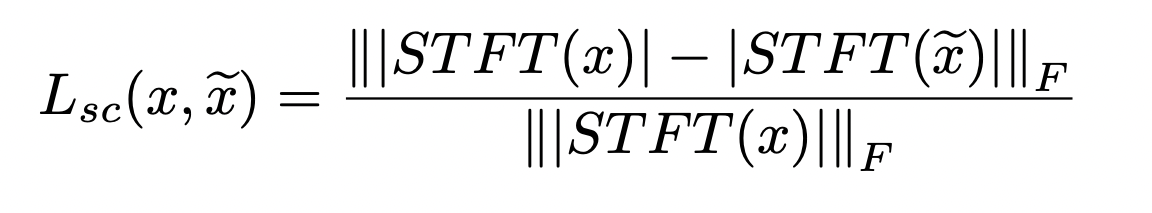

Magnitude loss의 수식은 다음과 같이 정의된다.

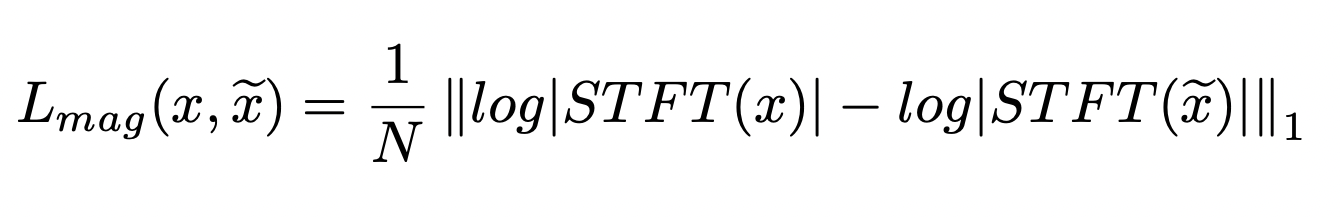

최종 Multi-resolution loss의 수식은 다음과 같다.

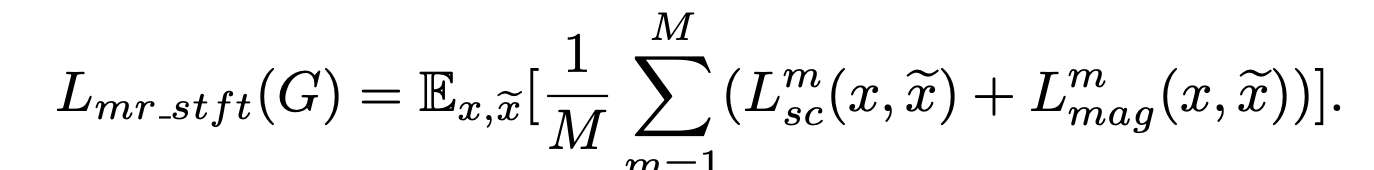

In [ ]:
"""STFT-based loss 계산."""
"""Generator가 생성해낸 wav를 다시 STFT로 mel로 전환해서 loss를 계산한 뒤 전파하는 방식."""
"""여기서 정의한 loss를 Full-band, Sub-band 차원에서 모두 적용한 것이 Multiband-MelGAN의 loss function이 됨."""

import tensorflow as tf


class TFSpectralConvergence(tf.keras.layers.Layer):
    """Spectral convergence loss."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): 실제값의 STFT version.
            x_mag (Tensor): 예측값의 STFT version.
        Returns:
            Tensor: Spectral convergence loss.
        """
        return tf.norm(y_mag - x_mag, ord="fro", axis=(-2, -1)) / tf.norm(
            y_mag, ord="fro", axis=(-2, -1)
        )



class TFLogSTFTMagnitude(tf.keras.layers.Layer):
    """Log STFT magnitude loss module."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): 실제값의 STFT version.
            x_mag (Tensor): 예측값의 STFT version.
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return tf.abs(tf.math.log(y_mag) - tf.math.log(x_mag))


class TFSTFT(tf.keras.layers.Layer):
    """위 두 종류의 loss를 전부 계산하는 클래스 작성."""

    def __init__(self, frame_length=600, frame_step=120, fft_length=1024):
        """Initialize."""
        super().__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length
        self.spectral_convergenge_loss = TFSpectralConvergence()
        self.log_stft_magnitude_loss = TFLogSTFTMagnitude()

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): 실제값.
            x (Tensor): 예측값.
        Returns:
            Tensor: Spectral convergence loss value (pre-reduce).
            Tensor: Log STFT magnitude loss value (pre-reduce).
        """
        x_mag = tf.abs(
            tf.signal.stft(
                signals=x,
                frame_length=self.frame_length,
                frame_step=self.frame_step,
                fft_length=self.fft_length,
            )
        )
        y_mag = tf.abs(
            tf.signal.stft(
                signals=y,
                frame_length=self.frame_length,
                frame_step=self.frame_step,
                fft_length=self.fft_length,
            )
        )

        # nan 방지를 위해 아주 작은 random number 더해줌.
        x_mag = tf.clip_by_value(tf.math.sqrt(x_mag ** 2 + 1e-7), 1e-7, 1e3)
        y_mag = tf.clip_by_value(tf.math.sqrt(y_mag ** 2 + 1e-7), 1e-7, 1e3)

        sc_loss = self.spectral_convergenge_loss(y_mag, x_mag)
        mag_loss = self.log_stft_magnitude_loss(y_mag, x_mag)

        return sc_loss, mag_loss


class TFMultiResolutionSTFT(tf.keras.layers.Layer):
    """Multi resolution STFT loss module."""

    def __init__(
        self,
        fft_lengths=[1024, 2048, 512],
        frame_lengths=[600, 1200, 240],
        frame_steps=[120, 240, 50],
    ):
        """Initialize Multi resolution STFT loss module.
        Args:
            frame_lengths (list): List of FFT sizes.
            frame_steps (list): List of hop sizes.
            fft_lengths (list): List of window lengths.
        """
        super().__init__()
        assert len(frame_lengths) == len(frame_steps) == len(fft_lengths)
        self.stft_losses = []
        for frame_length, frame_step, fft_length in zip(
            frame_lengths, frame_steps, fft_lengths
        ):
            self.stft_losses.append(TFSTFT(frame_length, frame_step, fft_length))

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): 실제값.
            x (Tensor): 예측값.
        Returns:
            Tensor: Multi resolution spectral convergence loss value.
            Tensor: Multi resolution log STFT magnitude loss value.
        """
        sc_loss = 0.0
        mag_loss = 0.0
        for f in self.stft_losses:
            sc_l, mag_l = f(y, x)
            sc_loss += tf.reduce_mean(sc_l, axis=list(range(1, len(sc_l.shape))))
            mag_loss += tf.reduce_mean(mag_l, axis=list(range(1, len(mag_l.shape))))

        sc_loss /= len(self.stft_losses)
        mag_loss /= len(self.stft_losses)

        return sc_loss, mag_loss

# 2.3: MultiBand-MelGAN trainer class

In [ ]:
class MultiBandMelganTrainer(MelganTrainer):
    """MelGAN trainer class를 상속받아 MultiBandMelGANTrainer class를 작성할 수 있음."""

    def __init__(
        self,
        config,
        strategy,
        steps=0,
        epochs=0,
        is_generator_mixed_precision=False,
        is_discriminator_mixed_precision=False,
    ):
        super(MultiBandMelganTrainer, self).__init__(
            config=config,
            steps=steps,
            epochs=epochs,
            strategy=strategy,
            is_generator_mixed_precision=is_generator_mixed_precision,
            is_discriminator_mixed_precision=is_discriminator_mixed_precision,
        )

        # 평가지표로 spectral_convergence_loss, log_magnitude_loss 등 새로운 loss들이 추가되었고 목적함수가 subband, fullband 의 차원에서 종합적으로 제시됨.
        self.list_metrics_name = [
            "adversarial_loss",
            "subband_spectral_convergence_loss",
            "subband_log_magnitude_loss",
            "fullband_spectral_convergence_loss",
            "fullband_log_magnitude_loss",
            "gen_loss",
            "real_loss",
            "fake_loss",
            "dis_loss",
        ]

        self.init_train_eval_metrics(self.list_metrics_name)
        self.reset_states_train()
        self.reset_states_eval()

    def compile(self, gen_model, dis_model, gen_optimizer, dis_optimizer, pqmf):
        super().compile(gen_model, dis_model, gen_optimizer, dis_optimizer)
        # 위 MultiBand-MelGAN loss에서 제시한 최종 loss function class인 TFMultiResolutionSTFT을 활용해 loss를 정의함. subband와 fullband 양쪽의 차원에서 전부 정의할 수 있었음. 
        self.sub_band_stft_loss = TFMultiResolutionSTFT(
            **self.config["subband_stft_loss_params"]
        )
        self.full_band_stft_loss = TFMultiResolutionSTFT(
            **self.config["stft_loss_params"]
        )

        # Generator에 활용할 pqmf 역시 사용.
        self.pqmf = pqmf

    def compute_per_example_generator_losses(self, batch, outputs):
        #outputs는 generator 모델이 제안한 subband 형태의 텐서임.
        dict_metrics_losses = {}
        per_example_losses = 0.0

        audios = batch["audios"]
        #y_mb_hat은 여러 subband 차원의 음성임.
        y_mb_hat = outputs
        #outputs에 synthesis를 적용하면 y_hat 이라고 하는 fullband 차원의 음성이 생겨나게 됨. 
        y_hat = self.pqmf.synthesis(y_mb_hat)
        
        #audios는 target값이고 이 값에 pqmf.analysis 를 적용해 주면 subband 차원의 정답 음성 텐서를 만들어낼 수 있음.
        y_mb = self.pqmf.analysis(tf.expand_dims(audios, -1))
        #loss를 계산하기 위해 위 y_mb_hat과의 차원을 맞춰주기 위한 작업.
        
        y_mb = tf.transpose(y_mb, (0, 2, 1))  
        y_mb = tf.reshape(y_mb, (-1, tf.shape(y_mb)[-1]))  

        y_mb_hat = tf.transpose(y_mb_hat, (0, 2, 1))  
        y_mb_hat = tf.reshape(
            y_mb_hat, (-1, tf.shape(y_mb_hat)[-1])
        )  

        # subband 차원의 loss는 y_mb, y_mb_hat 간의 차이를 계산함으로서 얻어낼 수 있음.
        sub_sc_loss, sub_mag_loss = calculate_2d_loss(
            y_mb, y_mb_hat, self.sub_band_stft_loss
        )
        sub_sc_loss = tf.reduce_mean(
            tf.reshape(sub_sc_loss, [-1, self.pqmf.subbands]), -1
        )
        sub_mag_loss = tf.reduce_mean(
            tf.reshape(sub_mag_loss, [-1, self.pqmf.subbands]), -1
        )
        #fullband 차원의 loss는 audios, y_hat간의 차이를 계산함으로서 얻어낼 수 있음.
        full_sc_loss, full_mag_loss = calculate_2d_loss(
            audios, tf.squeeze(y_hat, -1), self.full_band_stft_loss
        )

        # subband loss와 fullband loss의 가중합으로 generator loss를 정의.
        gen_loss = 0.5 * (sub_sc_loss + sub_mag_loss) + 0.5 * (
            full_sc_loss + full_mag_loss
        )
        # discriminator 의 학습 시점 정의
        if self.steps >= self.config["discriminator_train_start_steps"]:
            #여기서의 p_hat 이란 discriminator가 y_hat이라는 fullband 차원의 합성 음성이 원본 음성이라고 평가할 확률을 의미함. 1에 가까울 수록 원본 음성과의 유사도가 높음.
            p_hat = self._discriminator(y_hat)
            #p는 discriminator가 audios라는 원본 음성을 원본 음성으로 평가할 확률을 의미함. 1에 가까울 수록 discriminator 의 평가 성능이 좋음.
            p = self._discriminator(tf.expand_dims(audios, 2))
            adv_loss = 0.0
            #p_hat 은 3개의 discriminator가 각자 제시한 확률들의 리스트이므로 for문을 활용한 iteration을 해 주어야 여러 차원에서 adversarial loss를 계산할 수 있음.
            for i in range(len(p_hat)):
                adv_loss += calculate_3d_loss(
                    tf.ones_like(p_hat[i][-1]), p_hat[i][-1], loss_fn=self.mse_loss
                )
            #mean loss 계산을 위해 i+1로 나눠주어 normalize.
            adv_loss /= i + 1
            #gen_loss에 adv_loss의 가중합을 더해줌.
            gen_loss += self.config["lambda_adv"] * adv_loss

            dict_metrics_losses.update({"adversarial_loss": adv_loss},)

        dict_metrics_losses.update({"gen_loss": gen_loss})
        dict_metrics_losses.update({"subband_spectral_convergence_loss": sub_sc_loss})
        dict_metrics_losses.update({"subband_log_magnitude_loss": sub_mag_loss})
        dict_metrics_losses.update({"fullband_spectral_convergence_loss": full_sc_loss})
        dict_metrics_losses.update({"fullband_log_magnitude_loss": full_mag_loss})

        per_example_losses = gen_loss
        return per_example_losses, dict_metrics_losses

    def compute_per_example_discriminator_losses(self, batch, gen_outputs):
        #이제는 discriminator loss를 정의할 필요가 있음.
        #여러 subband 차원의 예측값들인 y_mb_hat 정의.
        y_mb_hat = gen_outputs
        #y_mb_hat에 pqmf.synthesis를 거쳐준 fullband 차원의 예측값인 y_hat 정의.
        y_hat = self.pqmf.synthesis(y_mb_hat)
        (
            per_example_losses,
            dict_metrics_losses,
        ) = super().compute_per_example_discriminator_losses(batch, y_hat)
        return per_example_losses, dict_metrics_losses

    def generate_and_save_intermediate_result(self, batch):
        """중간 결과 저장."""
        import matplotlib.pyplot as plt

        y_mb_batch_ = self.one_step_predict(batch)  # [B, T // subbands, subbands]
        y_batch = batch["audios"]
        utt_ids = batch["utt_ids"]

        # convert to tensor.
        # sample 한 개로 test 해 보기.
        try:
            y_mb_batch_ = y_mb_batch_.values[0].numpy()
            y_batch = y_batch.values[0].numpy()
            utt_ids = utt_ids.values[0].numpy()
        except Exception:
            y_mb_batch_ = y_mb_batch_.numpy()
            y_batch = y_batch.numpy()
            utt_ids = utt_ids.numpy()

        y_batch_ = self.pqmf.synthesis(y_mb_batch_).numpy()  # [B, T, 1]

        # 디렉토리 설정.
        dirname = os.path.join(self.config["outdir"], f"predictions/{self.steps}steps")
        #outdir라는 저장용 디렉토리가 없으면 새로이 만들어 줘야함.
        if not os.path.exists(dirname):
            os.makedirs(dirname)

        for idx, (y, y_) in enumerate(zip(y_batch, y_batch_), 0):
            # convert to ndarray
            y, y_ = tf.reshape(y, [-1]).numpy(), tf.reshape(y_, [-1]).numpy()

            # 합성음 & 실제음 간의 차이 시각화한 정보 역시 png 파일 형태로 저장.
            utt_id = utt_ids[idx]
            figname = os.path.join(dirname, f"{utt_id}.png")
            plt.subplot(2, 1, 1)
            plt.plot(y)
            plt.title("groundtruth speech")
            plt.subplot(2, 1, 2)
            plt.plot(y_)
            plt.title(f"generated speech @ {self.steps} steps")
            plt.tight_layout()
            plt.savefig(figname)
            plt.close()

            # _ref라고 하는 실제음과 _gen이라고 하는 합성음을 wav 형태로 audiolize한 정보 역시 wav 파일로 outdir에 저장.  이 둘을 비교해 볼 수 있음.
            y = np.clip(y, -1, 1)
            y_ = np.clip(y_, -1, 1)
            sf.write(
                figname.replace(".png", "_ref.wav"),
                y,
                self.config["sampling_rate"],
                "PCM_16",
            )
            sf.write(
                figname.replace(".png", "_gen.wav"),
                y_,
                self.config["sampling_rate"],
                "PCM_16",
            )

# 3.0: (Conclusion) MultiBand-MelGAN training session

본 주피터 노트북의 시작 부분에서도 언급하였듯이 상기한 코드들은 실행에 그 목적이 있는 것이 아니라 MelGAN에서 MultiBand-MelGAN으로 이어지는 전반적인 흐름에서 주목해 보아야 할 주요 코드들과 개념을 간단히 설명하는 데 그 의의가 있다. 상기 코드들을 실행하려면 필요 라이브러리나 추가 객체 몇 개를 새로이 지정해야 한다. 

따라서 코드 구현을 위해서는 코드의 원본 출처인 tensorflowTTS 의 github에서 .py 파일들을 불러와 직접 main()을 통해 직접 실행하는 것이 좋다.

아래는 저희 TTS 모델 내 vocoder로 활용했던 MultiBand-MelGAN을 main()에서 실행할 수 있게 하는 코드들에 대한 제반 설명을 담고 있다. 이 코드 내용을 참고하여 독자분들이 성공적인 MultiBand-MelGAN 구현을 할 수 있었으면 좋겠다.

In [ ]:
def main():
    
    parser = argparse.ArgumentParser(
        description="Train MultiBand MelGAN (See detail in examples/multiband_melgan/train_multiband_melgan.py)"
    )
    #학습 데이터 디렉토리.
    parser.add_argument(
        "--train-dir",
        default=None,
        type=str,
        help="directory including training data. ",
    )
    #검증 데이터 디렉토리.
    parser.add_argument(
        "--dev-dir",
        default=None,
        type=str,
        help="directory including development data. ",
    )
    #norm mels와 raw mels 중 무얼 활용할 지에 대한 것. default 는 norm mels.
    parser.add_argument(
        "--use-norm", default=1, type=int, help="use norm mels for training or raw."
    )
    #결과 저장 디렉토리 지정.
    parser.add_argument(
        "--outdir", type=str, required=True, help="directory to save checkpoints."
    )
    #환경변수가 저장된 yaml 포맷 파일. 
    parser.add_argument(
        "--config", type=str, required=True, help="yaml format configuration file."
    )
    #checkpoint 정보.
    parser.add_argument(
        "--resume",
        default="",
        type=str,
        nargs="?",
        help='checkpoint file path to resume training. (default="")',
    )
    #학습 과정 logging 의 세세함 정도를 결정. 0으로 설정시 학습 시 logging이 없음. Default = 1
    parser.add_argument(
        "--verbose",
        type=int,
        default=1,
        help="logging level. higher is more logging. (default=1)",
    )
    #Mixed precision 을 사용할 지에 대한 것.
    parser.add_argument(
        "--generator_mixed_precision",
        default=0,
        type=int,
        help="using mixed precision for generator or not.",
    )
    parser.add_argument(
        "--discriminator_mixed_precision",
        default=0,
        type=int,
        help="using mixed precision for discriminator or not.",
    )
    #pretrained 데이터 활용 시 .h5 포멧의 generator 가중치 파일을 제시. 
    parser.add_argument(
        "--pretrained",
        default="",
        type=str,
        nargs="?",
        help="path of .h5 mb-melgan generator to load weights from",
    )
    args = parser.parse_args()

    STRATEGY = return_strategy()

    # 위 args 에 주어진 Mixed precision에 따라 달라지는 학습 방식. 
    if args.generator_mixed_precision == 1 or args.discriminator_mixed_precision == 1:
        tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

    args.generator_mixed_precision = bool(args.generator_mixed_precision)
    args.discriminator_mixed_precision = bool(args.discriminator_mixed_precision)

    args.use_norm = bool(args.use_norm)

    # Logging 의 수준. verbose > 1 일 때에는 DEBUG 수준의 logging 제공.
    if args.verbose > 1:
        logging.basicConfig(
            level=logging.DEBUG,
            stream=sys.stdout,
            format="%(asctime)s (%(module)s:%(lineno)d) %(levelname)s: %(message)s",
        )
    #verbose = 1일 때에는 기본적인 INFO 수준의 logging 제공.
    elif args.verbose > 0:
        logging.basicConfig(
            level=logging.INFO,
            stream=sys.stdout,
            format="%(asctime)s (%(module)s:%(lineno)d) %(levelname)s: %(message)s",
        )
    #verbose = 1 일 때에는 DEBUG/INFO 정보 제공하지 않음.
    else:
        logging.basicConfig(
            level=logging.WARN,
            stream=sys.stdout,
            format="%(asctime)s (%(module)s:%(lineno)d) %(levelname)s: %(message)s",
        )
        logging.warning("Skip DEBUG/INFO messages")

    # 결과 저장 outdir 디렉토리에 대한 것.
    if not os.path.exists(args.outdir):
        os.makedirs(args.outdir)

    # 사용자가 필수 arguments를 제대로 입력했는지 여부에 대한 것.
    if args.train_dir is None:
        raise ValueError("Please specify --train-dir")
    if args.dev_dir is None:
        raise ValueError("Please specify either --valid-dir")

    # 환경변수 저장 및 불러오기
    with open(args.config) as f:
        config = yaml.load(f, Loader=yaml.Loader)
    config.update(vars(args))
    config["version"] = tensorflow_tts.__version__
    with open(os.path.join(args.outdir, "config.yml"), "w") as f:
        yaml.dump(config, f, Dumper=yaml.Dumper)
    for key, value in config.items():
        logging.info(f"{key} = {value}")

    # 데이터셋 환경변수 설정
    if config["remove_short_samples"]:
        mel_length_threshold = config["batch_max_steps"] // config[
            "hop_size"
        ] + 2 * config["multiband_melgan_generator_params"].get("aux_context_window", 0)
    else:
        mel_length_threshold = None

    if config["format"] == "npy":
        audio_query = "*-wave.npy"
        mel_query = "*-raw-feats.npy" if args.use_norm is False else "*-norm-feats.npy"
        audio_load_fn = np.load
        mel_load_fn = np.load
    else:
        raise ValueError("Only npy are supported.")

    # Train, valid dataset 기반으로 데이터셋 생성.
    train_dataset = AudioMelDataset(
        root_dir=args.train_dir,
        audio_query=audio_query,
        mel_query=mel_query,
        audio_load_fn=audio_load_fn,
        mel_load_fn=mel_load_fn,
        mel_length_threshold=mel_length_threshold,
    ).create(
        is_shuffle=config["is_shuffle"],
        map_fn=lambda items: collater(
            items,
            batch_max_steps=tf.constant(config["batch_max_steps"], dtype=tf.int32),
            hop_size=tf.constant(config["hop_size"], dtype=tf.int32),
        ),
        allow_cache=config["allow_cache"],
        batch_size=config["batch_size"]
        * STRATEGY.num_replicas_in_sync
        * config["gradient_accumulation_steps"],
    )

    valid_dataset = AudioMelDataset(
        root_dir=args.dev_dir,
        audio_query=audio_query,
        mel_query=mel_query,
        audio_load_fn=audio_load_fn,
        mel_load_fn=mel_load_fn,
        mel_length_threshold=mel_length_threshold,
    ).create(
        is_shuffle=config["is_shuffle"],
        map_fn=lambda items: collater(
            items,
            batch_max_steps=tf.constant(
                config["batch_max_steps_valid"], dtype=tf.int32
            ),
            hop_size=tf.constant(config["hop_size"], dtype=tf.int32),
        ),
        allow_cache=config["allow_cache"],
        batch_size=config["batch_size"] * STRATEGY.num_replicas_in_sync,
    )

    # MultiBand-MelGAN trainer 객체 불러오기.
    trainer = MultiBandMelganTrainer(
        steps=0,
        epochs=0,
        config=config,
        strategy=STRATEGY,
        is_generator_mixed_precision=args.generator_mixed_precision,
        is_discriminator_mixed_precision=args.discriminator_mixed_precision,
    )

    with STRATEGY.scope():
        # Generator, Discriminator 객체 불러오기.
        generator = TFMelGANGenerator(
            MultiBandMelGANGeneratorConfig(
                **config["multiband_melgan_generator_params"]
            ),
            name="multi_band_melgan_generator",
        )

        discriminator = TFMelGANMultiScaleDiscriminator(
            MultiBandMelGANDiscriminatorConfig(
                **config["multiband_melgan_discriminator_params"]
            ),
            name="multi_band_melgan_discriminator",
        )
        #Synthesis / Analysis 에 활용할 PQMF 클래스 불러오기.
        pqmf = TFPQMF(
            MultiBandMelGANGeneratorConfig(
                **config["multiband_melgan_generator_params"]
            ),
            dtype=tf.float32,
            name="pqmf",
        )

        # dummy input to build model.
        fake_mels = tf.random.uniform(shape=[1, 100, 80], dtype=tf.float32)
        y_mb_hat = generator(fake_mels)
        y_hat = pqmf.synthesis(y_mb_hat)
        discriminator(y_hat)

        #pretrained 데이터가 args에 입력되었다면 미리 학습된 가중치 모델 불러오기.

        if len(args.pretrained) > 1:
            generator.load_weights(args.pretrained)
            logging.info(
                f"Successfully loaded pretrained weight from {args.pretrained}."
            )

        generator.summary()
        discriminator.summary()

        # Optimizer 정의. Adam을 기반으로 하고 config에 제시된 각종 parameters 들을 사용해 설정 마무리.
        generator_lr_fn = getattr(
            tf.keras.optimizers.schedules, config["generator_optimizer_params"]["lr_fn"]
        )(**config["generator_optimizer_params"]["lr_params"])
        discriminator_lr_fn = getattr(
            tf.keras.optimizers.schedules,
            config["discriminator_optimizer_params"]["lr_fn"],
        )(**config["discriminator_optimizer_params"]["lr_params"])

        gen_optimizer = tf.keras.optimizers.Adam(
            learning_rate=generator_lr_fn,
            amsgrad=config["generator_optimizer_params"]["amsgrad"],
        )
        dis_optimizer = tf.keras.optimizers.Adam(
            learning_rate=discriminator_lr_fn,
            amsgrad=config["discriminator_optimizer_params"]["amsgrad"],
        )
    
    trainer.compile(
        gen_model=generator,
        dis_model=discriminator,
        gen_optimizer=gen_optimizer,
        dis_optimizer=dis_optimizer,
        pqmf=pqmf,
    )

    # 학습 시작.
    try:
        trainer.fit(
            train_dataset,
            valid_dataset,
            saved_path=os.path.join(config["outdir"], "checkpoints/"),
            resume=args.resume,
        )
    #사용자가 런타임 재시작 등의 이슈로 cell interrupt 를 할 때 checkpoint를 저장할 수 있게 해줌.
    except KeyboardInterrupt:
        trainer.save_checkpoint()
        logging.info(f"Successfully saved checkpoint @ {trainer.steps}steps.")


#본 파일을 .py형태로 직접 실행할 때 main() 함수 실행.
if __name__ == "__main__":
    main()



# 3.1: (Example) MultiBand-MelGAN training process

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python /content/gdrive/MyDrive/Project/TTS_audiobook/TensorflowTTS/TensorFlowTTS/examples/multiband_melgan/train_multiband_melgan_real3.py\ 
#train_multiband_melgan 파일 실행. 각종 자잘한 오류들을 디버깅 한 뒤의 코드를 train_multiband_melgan_real3.py로 수정 및 저장함.
  --train-dir /content/gdrive/MyDrive/Project/TTS_audiobook/TensorflowTTS/dump_kss/train/ \ 
  #학습 데이터 폴더 디렉토리 제시. 이 디렉토리 내에는 preprocess & normalize 를 거친 원본 음성들과 기타 정보들이 있음.
  --dev-dir /content/gdrive/MyDrive/Project/TTS_audiobook/TensorflowTTS/dump_kss/valid/ \ 
  #검증 데이터 폴더 디렉토리 제시. 이 디렉토리 내에는 validation 을 위해 따로 분류된 원본 음성들과 기타 정보들이 있음.
  --outdir /content/gdrive/MyDrive/Project/TTS_audiobook/TensorflowTTS/exp/train.multiband_melgan.v1/ \
  # Visualization png, Audiolization wav 및 generator, discriminator 의 가중치 모델 파일들, checkpoint 정보등이 들어가게 될 outdir를 설정.
  --config /content/gdrive/MyDrive/Project/TTS_audiobook/TensorflowTTS/TensorFlowTTS/examples/multiband_melgan/conf/multiband_melgan_test.v1.yaml \
  #multiband_melgan을 위한 각종 환경변수 지정 폴더 디렉토리 제시. 메모리 용량이나 컴퓨터 성능 때문에 train step 등 hyperparameter들을 살짝 수정해서 multiband_melgan_test.v1.yaml로 저장함.
  --use-norm 1 \
  #raw mel과 normalized mel 중 어느 것을 학습에 활용할 것인지 정보 제공. 둘 다 실험해 보고 더 자연스러운 음성을 생성하는 방식을 채택하는 것이 이상적.
  --generator_mixed_precision 0 \
  #mixed_precision 사용 여부에 관한 것. 사용하게 되면 GPU 환경에 따라 오류가 생길 수 있음. Default = 0
  --resume '' \
  #런타임 끊김 등 이슈로 여러 차례에 걸쳐 모델을 학습해야 할 때 사용하는 checkpoint 불러오기 메소드. 
  --pretrained /content/gdrive/MyDrive/Project/TTS_audiobook/TensorflowTTS/Pretrained/generator-1000000.h5 
  #pretrained 데이터를 활용하고자 할 때 사용할 pretrained generator 제시. 본 프로젝트에서는 KSS datasets으로 1M step 학습된 pretrained 데이터를 활용함.